<a href="https://colab.research.google.com/github/dilthoms/ai-ml-assignments/blob/master/kaggle/kaggle-digits/kaggle-digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup kaggle cli and download dataset in google colab

Since all data is lost when google colab session ends, the six steps given below will download dataset from kaggle and save you from the trouble of downloading the dataset everytime. The first two steps below have to be done manually the first time. After that the rest of the steps can be executed by running the three cells (steps 3-6) below. You have to run these three cells to download the dataset everytime you start a new session. 
  

1. Download / create json credentials after creating an account in kaggle.  See https://github.com/Kaggle/kaggle-api for more details
2. Upload the kaggle.json file to your google drive
3. Run the script in the first cell below to download kaggle.json  to your colab environment
4. It will ask you to click on a link and enter the verification code
5. Install kaggle cli using pip install
6. Download the dataset




In [5]:
# Code from https://medium.com/@move37timm/using-kaggle-api-for-google-colaboratory-d18645f93648
# Create kaggle.json by following instructions at https://github.com/Kaggle/kaggle-api
# Upload kaggle.json to google drive
# Download kaggle.json to colab from the users google drive

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
if not os.path.exists(os.path.dirname(filename)):
  os.makedirs(os.path.dirname(filename))
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [6]:
# Install kaggle cli
!pip install kaggle

In [7]:
# Download the dataset for digit-recognizer chalenge
!kaggle competitions download -c digit-recognizer

 55% 5.00M/9.16M [00:00<00:00, 34.6MB/s]
100% 9.16M/9.16M [00:00<00:00, 44.8MB/s]
 82% 5.00M/6.09M [00:00<00:00, 32.7MB/s]
100% 6.09M/6.09M [00:00<00:00, 29.8MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 65.6MB/s]


# 2. Read data in pandas dataframe
1. Check train and test csv files have been downloaded
2. import pandas and numpy and create train and test dataframes from the respective csv files
3. Inspect the dataframes
4. Convert to numpy arrays for train, validation, and test set 

In [8]:
# Check train and test csv files exist
!ls -ltr
!unzip train.csv.zip
!unzip test.csv.zip

total 15864
drwxr-xr-x 1 root root    4096 Dec 18 16:52 sample_data
-rw-r--r-- 1 root root    2608 Jan 12 15:48 adc.json
-rw-r--r-- 1 root root 9606023 Jan 12 15:48 train.csv.zip
-rw-r--r-- 1 root root 6385593 Jan 12 15:48 test.csv.zip
-rw-r--r-- 1 root root  240909 Jan 12 15:48 sample_submission.csv
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
# Read the csv files using pandas
import pandas as pd
import numpy as np
df_tr = pd.read_csv('train.csv')
df_te = pd.read_csv('test.csv')


In [10]:
# Examine the contents of train.csv
# Contains 28x28 pixel values and the corresponding digit label
print (df_tr.info())
df_tr.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Examine the contents of test.csv
# Contains only the 28x28 pixel values without the corresponding digit label
print (df_te.info())
df_te.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Partition the training data into pixels (independent variable) and label (dependent variable)
X = np.asarray(df_tr.drop('label',axis=1),dtype=np.uint8).reshape(-1,28,28)
yhat = np.asarray(df_tr['label'])

np.random.seed(2)
# Generate random indices for creating a random validation set with 20% of the labelled data
validx = (np.random.uniform(size=len(X)) <= 0.2)

# Create training set (80% of the labelled data)
X_trn = X[~validx]
y_trn = yhat[~validx]

# Create validation set (20% of the labelled data)
X_val = X[validx]
y_val = yhat[validx]

# Create the test set
X_tes = np.asarray(df_te,dtype=np.uint8).reshape(-1,28,28)

# 3. Visualize some of the data items
1. import matplotlib
2. Visualize the first few data items and verify the corresponding labels match

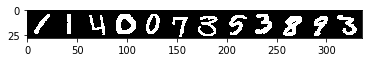

array([1, 1, 4, 0, 0, 7, 3, 5, 3, 8, 9, 3])

In [100]:
# Concatenate nvis images horizontally and visualize it using matplot lib
import matplotlib.pyplot as plt
nvis = 12
plt.imshow(np.concatenate(X_trn[:nvis],axis=1),cmap='gray',vmin=0,vmax=1)
plt.show()

# Print the corresponding labels to check they match
y_trn[:nvis]

# 4a. Create a fully connected neural network in pytorch

We follow the same steps as in [assignment 4](https://github.com/dilthoms/ai-ml-assignments/blob/master/AI-ML-Libs/sklearn-pytorch.ipynb)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
    
# Create a class and define the layers in the __init__
# and implement the forward propagation. Pytorch will automatically
# calculate the backward propagation for you. 

class SingleHidden_NN(nn.Module):
    '''
    A Neural Network with a single hidden layer.
    ''' 
    
    # Create a constructor and define the layers and activations
    def __init__(self, input_size,hidden_size,output_size):
        '''
        Arguments:
            input_size  : The number of neurons in the input layer
            hidden_size : The number of neurons in the hidden layer
            output_size : The number of neurons in the output layer
        '''
        super(SingleHidden_NN, self).__init__()
        self.input_size = input_size
        self.layernorm1 = nn.LayerNorm(input_size)
        # Define a pytorch linear layer that connects the input layer to the hidden layer
        self.layer1 = nn.Linear(input_size, hidden_size)
        # Define a pytorch linear layer that connects the hidden layer to the output layer
        self.layernorm2 = nn.LayerNorm(hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        

         
    def forward(self, x):
      '''
      Implement forward propagation with relu activation for the hidden layer.
      Arguments:
          x      : The input x
      Returns:
          output : The linear activation from the output layer
      '''
      output = self.layer2(self.layernorm2(F.relu(self.layer1(self.layernorm1(x.view(-1,self.input_size))))))
      return output

# 4b. Create a convolutional neural network in pytorch


In [0]:

class ConvNN(nn.Module):
    def __init__(self):
      super(ConvNN, self).__init__()
      self.conv0_bn = nn.BatchNorm2d(1)
      self.conv1 = nn.Conv2d(1,64,3,padding=1)
      self.conv11 = nn.Conv2d(64,64,3,padding=1)
      self.conv1_bn = nn.BatchNorm2d(64)
      self.conv11_bn = nn.BatchNorm2d(64)
      self.conv1l_bn = nn.BatchNorm2d(64)
      self.conv2 = nn.Conv2d(64,128,3,padding=1)
      self.conv22 = nn.Conv2d(128,128,3,padding=1)
      self.conv2_bn = nn.BatchNorm2d(128)
      self.conv22_bn = nn.BatchNorm2d(128)
      self.conv2l_bn = nn.BatchNorm2d(128)
      self.conv3 = nn.Conv2d(128,256,3,padding=1)
      self.conv33 = nn.Conv2d(256,256,3,padding=1)
      self.conv3_bn = nn.BatchNorm2d(256)
      self.conv33_bn = nn.BatchNorm2d(256)
      self.conv3l_bn = nn.BatchNorm2d(256)
      self.locpool1 = nn.Conv2d(64,64,2,2,padding=0)
      self.locpool2 = nn.Conv2d(128,128,2,2,padding=0)
      self.locpool3 = nn.Conv2d(256,256,2,2,padding=0)
      self.glopool = nn.AdaptiveMaxPool2d((1,1))
      self.dropout = nn.Dropout(0.5)
      self.layernorm1 = nn.LayerNorm(2048)
      self.lin1 = nn.Linear(256,256)
      self.layernorm2 = nn.LayerNorm(256)
      self.lin2 = nn.Linear(256,10)
      
    def forward(self,x):
      #print(x.shape)
      #x = x.permute(0,3,2,1)
      x = self.conv1_bn(F.relu(self.conv1((x))))
      x = self.conv11_bn(F.relu(self.conv11((x))))
      x = self.conv1l_bn(F.relu(self.locpool1(x)))
      x = self.conv2_bn(F.relu(self.conv2(x)))
      x = self.conv22_bn(F.relu(self.conv22(x)))
      x = self.conv2l_bn(F.relu(self.locpool2(x)))
      x = self.conv3_bn(F.relu(self.conv3(x)))
      x = self.conv33_bn(F.relu(self.conv33(x)))
      x = self.conv3l_bn(F.relu(self.locpool3(x)))
      x = F.adaptive_avg_pool2d(x,(1,1))
      x = x.view(x.size(0),-1)
      x = F.relu(self.lin1(self.dropout(((x)))))
      x = self.lin2(self.dropout(((x))))
      return x


In [0]:
# Create a Dataset subclass for loading datasets in numpy arrays
# See https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import PIL 
import numpy as np
class Numpy_XY_Dataset(Dataset):
  '''
  Dataset subclass for the MNIST digits dataset
  '''
  
  def __init__(self,X,y,train=True):
    '''
    Create the independent and dependent variables
    '''
    super(Numpy_XY_Dataset,self).__init__()
    self.X = X
    self.y = y
    assert(len(X)==len(y))
    self.train = train
    self.trtsfm = transforms.Compose([transforms.RandomAffine(degrees=5,shear=5,scale=(0.95,1.05)),transforms.ToTensor(),transforms.RandomErasing()])
    self.tetsfm = transforms.Compose([transforms.ToTensor()])
    
  def __len__(self):
    '''
    Return the size of the dataset
    '''
    return len(self.X)
  
  def __getitem__(self,idx):
    '''
    Return the data item at index idx
    '''
    if self.train:
      return self.trtsfm(PIL.Image.fromarray(self.X[idx])),self.y[idx]
      #return self.X[idx],self.y[idx]
    else:
      return self.tetsfm(PIL.Image.fromarray(self.X[idx])),self.y[idx]
        

In [177]:
# Write training loop
import torch.optim as optim
num_epochs = 50
model = ConvNN().cuda()
lossFunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=15)
ds_trn = Numpy_XY_Dataset(X_trn,y_trn,train=True)
ds_val = Numpy_XY_Dataset(X_val,y_val,train=False)

dl_trn = DataLoader(dataset=ds_trn,batch_size=256,shuffle=True)
dl_val = DataLoader(dataset=ds_val,batch_size=256,shuffle=False)

# Write the training loop
best = 0
for epoch in range(num_epochs):
  scheduler.step()
  model.train(True) 
  for imgs,labels in dl_trn:
    imgs,labels = imgs.cuda(),labels.cuda()
    # Calculate the activations for the training set using forward propagation
    out = model(imgs)
    
    # Calculate the value of loss using the output of the forward propagation and the 
    # ground truth for the training set
    loss = lossFunction(out,labels)
    
    # Reset the gradients to zero
    optimizer.zero_grad()
    
    # Run the backward propagation and update the parameters by one step
    loss.backward()
    optimizer.step()
    
  model.train(False)
  correct = 0
  for imgs,labels in dl_val:
    imgs,labels = imgs.cuda(),labels.cuda()
    out = model(imgs)
    valloss = lossFunction(out,labels)
    _,out = torch.max(out,1)
    correct += torch.sum(out == labels.data)
  acc =  correct.float()/len(ds_val)
  if acc > best:
    best = acc
    torch.save(model.state_dict(),"digit-"+str(np.round(acc.cpu().numpy(),decimals=5))+".pth")
  print('Epoch [{}/{}], Train loss: {:.4f}' .format(epoch, num_epochs, loss.item()))
  print('Epoch [{}/{}], Val loss: {:.4f} and acc: {:.4f}' .format(epoch, num_epochs, valloss, acc))

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch [0/50], Train loss: 0.4098
Epoch [0/50], Val loss: 0.1761 and acc: 0.9437
Epoch [1/50], Train loss: 0.4031
Epoch [1/50], Val loss: 0.2704 and acc: 0.9372
Epoch [2/50], Train loss: 0.1115
Epoch [2/50], Val loss: 0.1433 and acc: 0.9782
Epoch [3/50], Train loss: 0.2689
Epoch [3/50], Val loss: 0.0958 and acc: 0.9824
Epoch [4/50], Train loss: 0.4383
Epoch [4/50], Val loss: 0.0957 and acc: 0.9886
Epoch [5/50], Train loss: 0.1408
Epoch [5/50], Val loss: 0.0904 and acc: 0.9881
Epoch [6/50], Train loss: 0.0688
Epoch [6/50], Val loss: 0.1071 and acc: 0.9856
Epoch [7/50], Train loss: 0.1206
Epoch [7/50], Val loss: 0.0650 and acc: 0.9892
Epoch [8/50], Train loss: 0.0806
Epoch [8/50], Val loss: 0.0440 and acc: 0.9814
Epoch [9/50], Train loss: 0.3952
Epoch [9/50], Val loss: 0.0314 and acc: 0.9901
Epoch [10/50], Train loss: 0.1119
Epoch [10/50], Val loss: 0.0585 and acc: 0.9905
Epoch [11/50], Train loss: 0.4038
Epoch [11/50], Val loss: 0.0625 and acc: 0.9887
Epoch [12/50], Train loss: 0.1237
Ep

In [178]:
model = ConvNN()
fn = "digit-"+str(np.round(best.cpu().numpy(),decimals=5))+".pth"
print(fn)
model.load_state_dict(torch.load(fn))
model.eval()

digit-0.99452.pth


ConvNN(
  (conv0_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv11_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1l_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2l_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2

In [0]:
# Generate predictions using the trained model
# A hack for dataloader for X_tes by passing zeros as labels
model = model.cuda()
ds_tes = Numpy_XY_Dataset(X_tes,np.zeros(len(X_tes)),train=False)
dl_tes = DataLoader(dataset=ds_tes,batch_size=256,shuffle=False)
res = []
for imgs,labels in dl_tes:
    imgs,labels = imgs.cuda(),labels.cuda()
    out = model(imgs)
    _,out = torch.max(out,1)
    res += (out.cpu().numpy().tolist())

In [0]:
# Convert the results to a pandas dataframe
sub = pd.DataFrame({"ImageId":np.arange(1,28001),"Label":res})

# Create the submission csv file from the dataframe
sub.to_csv("sub.csv",index=False)

In [181]:
# Submit the csv file to kaggle using the kaggle api
!kaggle competitions submit -c digit-recognizer -f sub.csv -m "submission_bn2"



100% 208k/208k [00:03<00:00, 70.5kB/s]
403 - Your team has used its submission allowance (5 of 5). This resets at midnight UTC (5.4 hours from now).


In [163]:
!ls

adc.json	   digit-0.97271.pth  digit-0.98486.pth  digit-0.9919.pth
digit-0.11621.pth  digit-0.97318.pth  digit-0.98498.pth  digit-0.99201.pth
digit-0.18272.pth  digit-0.9739.pth   digit-0.9851.pth	 digit-0.99213.pth
digit-0.23909.pth  digit-0.97449.pth  digit-0.9857.pth	 digit-0.99225.pth
digit-0.27092.pth  digit-0.97461.pth  digit-0.98653.pth  digit-0.99237.pth
digit-0.5143.pth   digit-0.97473.pth  digit-0.98665.pth  digit-0.99249.pth
digit-0.74338.pth  digit-0.97545.pth  digit-0.98677.pth  digit-0.99261.pth
digit-0.83135.pth  digit-0.97557.pth  digit-0.98713.pth  digit-0.99273.pth
digit-0.87783.pth  digit-0.97604.pth  digit-0.98737.pth  digit-0.99285.pth
digit-0.90262.pth  digit-0.9764.pth   digit-0.98749.pth  digit-0.99297.pth
digit-0.91836.pth  digit-0.97664.pth  digit-0.98796.pth  digit-0.99309.pth
digit-0.93051.pth  digit-0.97771.pth  digit-0.98808.pth  digit-0.99321.pth
digit-0.93647.pth  digit-0.97807.pth  digit-0.98832.pth  digit-0.99333.pth
digit-0.94207.pth  digit-0.97831.pt

In [167]:
!ls -ltr

total 1125408
-rw-r--r-- 1 root root 76775041 Dec 11 20:01 train.csv
-rw-r--r-- 1 root root 51118296 Dec 11 20:01 test.csv
drwxr-xr-x 1 root root     4096 Dec 18 16:52 sample_data
-rw-r--r-- 1 root root     2608 Jan 12 15:48 adc.json
-rw-r--r-- 1 root root  9606023 Jan 12 15:48 train.csv.zip
-rw-r--r-- 1 root root  6385593 Jan 12 15:48 test.csv.zip
-rw-r--r-- 1 root root   240909 Jan 12 15:48 sample_submission.csv
-rw-r--r-- 1 root root  2604224 Jan 12 16:00 digit-0.97807.pth
-rw-r--r-- 1 root root  2604224 Jan 12 16:00 digit-0.98343.pth
-rw-r--r-- 1 root root  5995549 Jan 12 16:11 digit-0.97271.pth
-rw-r--r-- 1 root root  5995549 Jan 12 16:11 digit-0.98248.pth
-rw-r--r-- 1 root root  5995549 Jan 12 16:11 digit-0.98677.pth
-rw-r--r-- 1 root root  5995521 Jan 12 16:19 digit-0.97092.pth
-rw-r--r-- 1 root root  5995521 Jan 12 16:19 digit-0.98236.pth
-rw-r--r-- 1 root root  5995521 Jan 12 16:19 digit-0.98451.pth
-rw-r--r-- 1 root root  5995521 Jan 12 16:19 digit-0.9919.pth
-rw-r--r-- 1 roo